<a href="https://colab.research.google.com/github/YichengShen/segment-anything/blob/main/testing/sam-ksdd2/SAM-KSDD2%E5%BE%AE%E8%B0%83%EF%BC%88%E9%A2%84%E6%B5%8B%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SAM-KSDD2微调效果测试v1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 118.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.7 MB/s eta 0:00:00


In [ ]:
import cv2
import os
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

## KSDD2数据集

### 下载数据集

In [ ]:
!wget -O ksdd.zip https://go.vicos.si/kolektorsdd2

--2023-06-25 18:32:19--  https://go.vicos.si/kolektorsdd2
Resolving go.vicos.si (go.vicos.si)... 212.235.189.18
Connecting to go.vicos.si (go.vicos.si)|212.235.189.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://box.vicos.si/skokec/gostop/KolektorSDD2.zip [following]
--2023-06-25 18:32:20--  https://box.vicos.si/skokec/gostop/KolektorSDD2.zip
Resolving box.vicos.si (box.vicos.si)... 212.235.189.20
Connecting to box.vicos.si (box.vicos.si)|212.235.189.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 853126555 (814M) [application/zip]
Saving to: ‘ksdd.zip’

ksdd.zip            100%[===================>] 813.60M  13.5MB/s    in 61s     

2023-06-25 18:33:22 (13.3 MB/s) - ‘ksdd.zip’ saved [853126555/853126555]



In [ ]:
if not os.path.exists('data'):
    !mkdir data
    !unzip -q /content/ksdd.zip -d /content/data
    !rm /content/ksdd.zip

### 筛选数据

KSDD2的训练集中包含缺陷的图片有246张和不包含缺陷的图片有2085张，测试集中包含缺陷的图片有110张和不包含缺陷的图片有894张。

我们只使用包含缺陷的图片。

In [ ]:
def filter_data(folder):
    all_files = os.listdir(folder)
    mask_files = [f for f in all_files if f.endswith('_GT.png')]

    filtered = []
    for mask_file in mask_files:
        mask = cv2.imread(os.path.join(folder, mask_file), cv2.IMREAD_UNCHANGED)
        if mask is not None and not np.all(mask == 0):
            original_file = mask_file.replace('_GT', '')
            filtered.append((original_file, mask_file))

    return filtered

train_folder = "/content/data/train"
train_files = filter_data(train_folder)
print("训练集：", len(train_files))

test_folder = "/content/data/test"
test_files = filter_data(test_folder)
print("测试集：", len(test_files))

训练集： 246
测试集： 110


## 准备

### 加载微调后的模型

In [ ]:
import torch
from PIL import Image
from transformers import SamModel, SamProcessor

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [ ]:
checkpoint = torch.load('/content/drive/Shareddrives/SAM调研/SAM/SAM微调/20230625_150125_1e-06_0/checkpoint_28_1e-06_0.pth')

model.load_state_dict(checkpoint['model_state_dict'])

# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model = model.to(device)

### 加载没有微调的模型（做比较用）

In [ ]:
model_without_finetune = SamModel.from_pretrained("facebook/sam-vit-base").to(device)

###辅助函数

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_masks_on_image(raw_image, masks, scores):
    if len(masks.shape) == 4:
      masks = masks.squeeze()
    if scores.shape[0] == 1:
      scores = scores.squeeze()

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(9, 6))

    for i, (mask, score) in enumerate(zip(masks, scores)):
      mask = mask.cpu().detach()
      axes[i].imshow(np.array(raw_image))
      show_mask(mask, axes[i])
      axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
      axes[i].axis("off")
    plt.show()

In [ ]:
def get_bounding_box(ground_truth_map):
  # 根据掩码取边界框
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # 给框加一些干扰值
  # H, W = ground_truth_map.shape
  # x_min = max(0, x_min - np.random.randint(0, 20))
  # x_max = min(W, x_max + np.random.randint(0, 20))
  # y_min = max(0, y_min - np.random.randint(0, 20))
  # y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

## 可视化效果

22


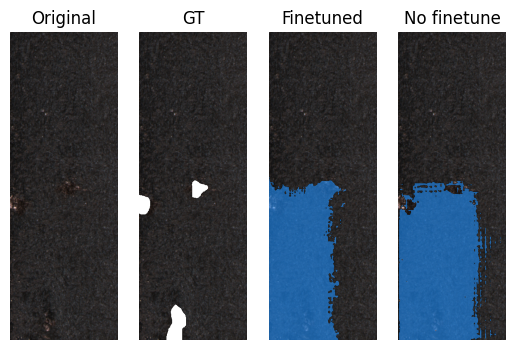

微调前的IoU： 0.9370606
微调后的IoU： 0.94065714
55


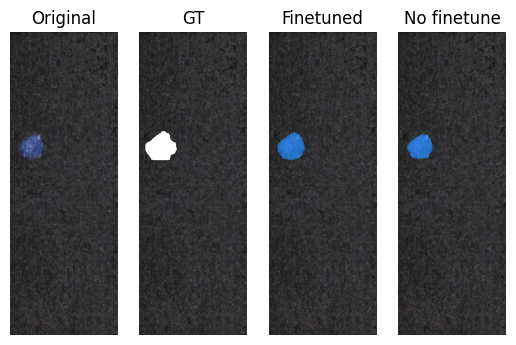

微调前的IoU： 0.988782
微调后的IoU： 0.98399746
44


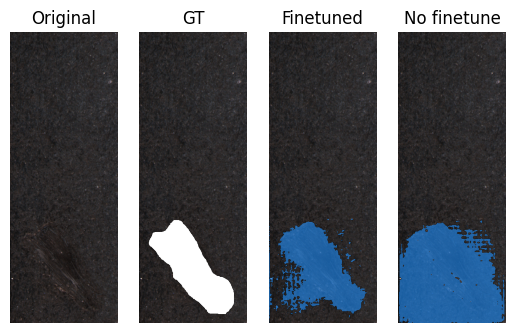

微调前的IoU： 0.9516991
微调后的IoU： 0.9162965
10


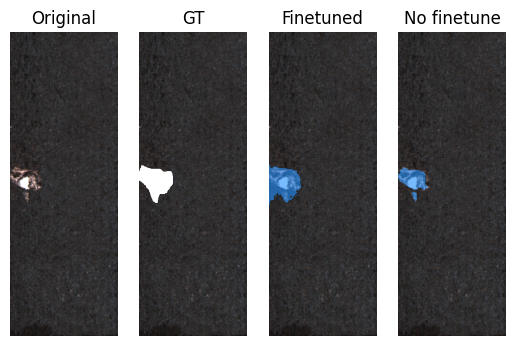

微调前的IoU： 0.9688089
微调后的IoU： 0.96831393
15


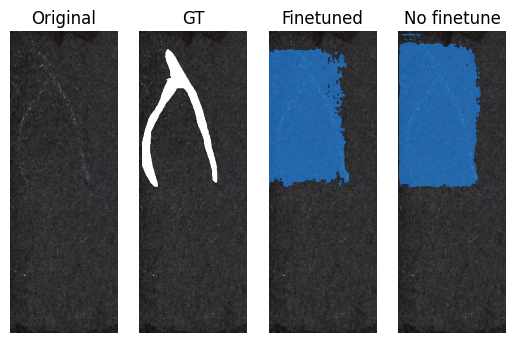

微调前的IoU： 0.9552413
微调后的IoU： 0.93403745
96


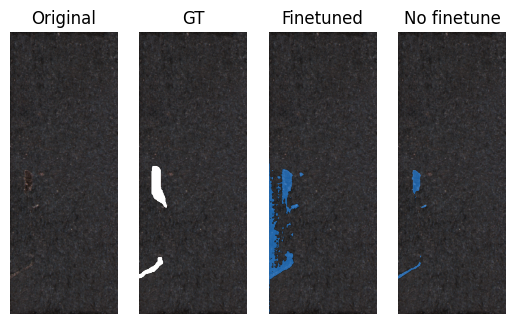

微调前的IoU： 0.8732754
微调后的IoU： 0.9331763
99


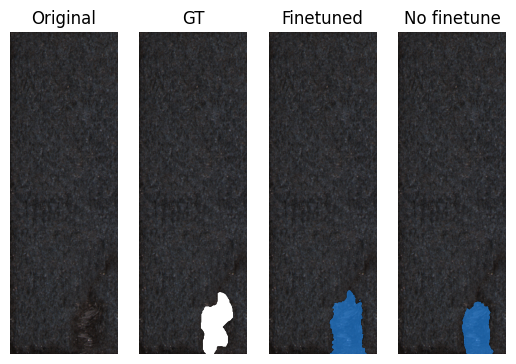

微调前的IoU： 0.95146704
微调后的IoU： 0.9545422
106


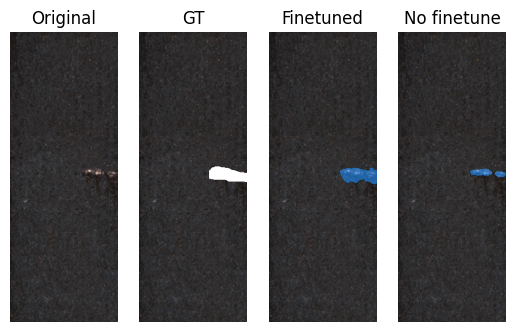

微调前的IoU： 0.9000749
微调后的IoU： 0.9570907
102


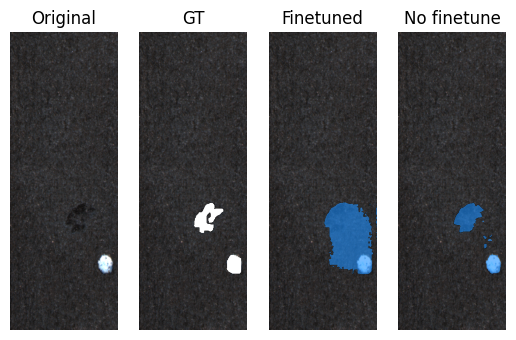

微调前的IoU： 0.95163167
微调后的IoU： 0.9606295


In [ ]:
test_folder = "/content/data/test"

idx_list = [22, 55, 44, 10, 15, 96, 99, 106, 102]

for idx in idx_list:
    print(idx)
    image_path = os.path.join(test_folder, test_files[idx][0])
    mask_path = os.path.join(test_folder, test_files[idx][1])

    image = cv2.imread(image_path)
    ground_truth_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # 计算边界框作为提示
    prompt = get_bounding_box(ground_truth_mask)

    inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)

    # 预测
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    output_masks = processor.image_processor.post_process_masks(
        outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
    )

    best_mask_idx = np.argmax(outputs.iou_scores.cpu().numpy())
    best_mask = output_masks[0][0][best_mask_idx]

    model_without_finetune.eval()
    with torch.no_grad():
        outputs_without_finetune = model_without_finetune(**inputs)

    output_masks_without_finetune = processor.image_processor.post_process_masks(
        outputs_without_finetune.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
    )

    best_idx_without_finetune = np.argmax(outputs_without_finetune.iou_scores.cpu().numpy())
    mask_without_finetune = output_masks_without_finetune[0][0][best_idx_without_finetune]

    fig, axes = plt.subplots(1, 4)

    axes[0].imshow(np.array(image))
    axes[0].set_title("Original")
    axes[0].axis("off")

    axes[1].imshow(np.array(image))
    show_mask(ground_truth_mask, axes[1])
    axes[1].set_title("GT")
    axes[1].axis("off")

    axes[2].imshow(np.array(image))
    show_mask(best_mask, axes[2])
    axes[2].set_title("Finetuned")
    axes[2].axis("off")

    axes[3].imshow(np.array(image))
    show_mask(mask_without_finetune, axes[3])
    axes[3].set_title("No finetune")
    axes[3].axis("off")

    plt.show()

    print("微调前的IoU：", np.max(outputs_without_finetune.iou_scores.cpu().numpy()))
    print("微调后的IoU：", np.max(outputs.iou_scores.cpu().numpy()))